In [1]:
import os
import re
import nltk
import nltk
nltk.download('punkt')
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atrit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atrit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#casefold() to enable case insensitive search
#filter by category/titel seperately
#

In [2]:
#opening data
raw_books = pd.read_csv('Books_data.csv')
raw_books.head(20)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada
5,5,67544,"toronto, ontario, canada",30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],toronto,ontario,canada
6,6,85526,"victoria, british columbia, canada",36.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],victoria,british columbia,canada
7,7,96054,"ottawa, ontario, canada",29.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
8,8,116866,"ottawa, ,",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,",",NaN
9,9,123629,"kingston, ontario, canada",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],kingston,ontario,canada


In [3]:
df = raw_books.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#removing unneeded columns
df.drop(columns = ['Unnamed: 0','location','isbn','img_s','img_m','city','age','state','Language','country','year_of_publication'],axis=1,inplace = True) 

#removing 9 in category
df.drop(index=df[df['Category'] == '9'].index, inplace=True)

#removing zero ratings
df.drop(index=df[df['rating'] == 0].index, inplace=True)

df['Category'] = df['Category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217314 entries, 1 to 982277
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      217314 non-null  int64 
 1   rating       217314 non-null  int64 
 2   book_title   217314 non-null  object
 3   book_author  217314 non-null  object
 4   publisher    217314 non-null  object
 5   img_l        217314 non-null  object
 6   Summary      217314 non-null  object
 7   Category     217314 non-null  object
dtypes: int64(2), object(6)
memory usage: 14.9+ MB


In [4]:
def custom_recommender(book_title):
    
    #ITEM-BASED
    book_title = str(book_title)
    if book_title in df['book_title'].values:
    
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'], values='rating')
                   
            book = user_book_df[book_title]  
            recom_data = pd.DataFrame(user_book_df.corrwith(book). \
                                      sort_values(ascending=False)).reset_index(drop=False)
            
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
                
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)
                    
            if recom_data.shape[0] - len(low_rating) > 5:
                recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]
            
            recom_data = recom_data[0:1]    
            recom_data.columns = ['book_title','corr']
            recommended_books = []
            for i in recom_data['book_title']:
                recommended_books.append(i)
                
            df_new = df[~df['book_title'].isin(recommended_books)]
            
               
            #CONTENT-BASED (Title, Author, Publisher, Category)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
        
            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
    
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]   
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:2]
                       
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                
            for i in books:
                recommended_books.append(i)
            
            df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #CONTENT-BASED (SUMMARY)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
                    
            summary_filtered = []
            for i in common_books['Summary']:
                
                i = re.sub("[^a-zA-Z]"," ",i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if not word in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)
            
            common_books['Summary'] = summary_filtered
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['Summary'])
            cosine_sim = cosine_similarity(count_matrix) 
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books2 = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:4]
            sorted_sim_books = sorted_sim_books2[:2]
            summary_books = []
            for i in range(len(sorted_sim_books)):
                summary_books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                               
            for i in summary_books:
                recommended_books.append(i)
                
            df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #TOP RATED OF CATEGORY
            category = common_books[common_books['book_title'] == book_title]['Category'].values[0]
            top_rated = common_books[common_books['Category'] == category].groupby('book_title').agg({'rating':'mean'}).reset_index()
            
            if top_rated.shape[0] == 1:
                recommended_books.append(common_books[common_books['index'] == sorted_sim_books2[2][0]]['book_title'].item())
                
            else:
                top_rated.drop(top_rated[top_rated['book_title'] == book_title].index[0],inplace=True)
                top_rated = top_rated.sort_values('rating',ascending=False).iloc[:1]['book_title'].values[0]
                recommended_books.append(top_rated)
                               
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', color="purple", size = 22)
            for i in range(len(recommended_books)):
        
                url = df.loc[df['book_title'] == recommended_books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == recommended_books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="purple",
                                 fontsize=18)
                fig.show()     

    else:
        print('Cant find book in dataset, please check spelling')

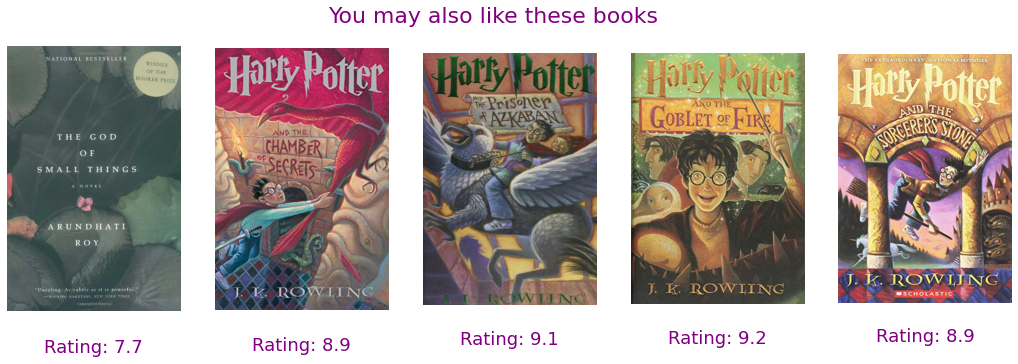

In [11]:
custom_recommender('Harry Potter and the Order of the Phoenix (Book 5)')